In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import inspect

import pandas as pd
import numpy as np

from cls2 import occur, plotting
from cls2.occur import *
from cls2.io import *

In [2]:
sysprops = pd.read_csv('legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
objects = pd.read_csv('legacy_tables/planet_list.csv')
trends = pd.read_csv('legacy_tables/trend_list.csv')

In [5]:
objects_real   = objects.query('status != "N" and status != "A" and status != "R"').reset_index(drop=True)
objects_good   = objects_real.query('mass != "nan"').reset_index(drop=True)
planets_s      = objects_good.query('(status == "S" or status == "SS") and mass > 10').reset_index(drop=True)
planets        = objects_good.query('status != "S" and status != "SS"').reset_index(drop=True)
planets_old    = planets.query('status == "K"').reset_index(drop=True)
planets_new    = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [6]:
hostnames = list(set(planets.hostname))

In [7]:
len(hostnames)

116

In [8]:
print(hostnames)

['12661', '50554', '75732', '31253', '11964a', '9826', '145675', '114762', '168443', 'gl317', '95735', '82943', '141399', '8574', 'hip57087', '141004', '177830', '97658', '222582', '130322', '13931', '45350', 'hip57050', '50499', '192263', '99492', 'hip74995', '32963', 'bd-103166', '108874', '115617', '156279', '136925', '107148', '45184', '34445', '4208', 'hip22627', '7924', '42618', 'hip83043', '37124', '143761', '216520', '90156', '28185', '210277', '16141', '154345', '192310', '3765', '190360', '187123', '46375', '186427', '181234', '72659', '175541', '117176', '195019', '92788', '179949', '87883', '189733', '145934', '209458', '49674', '3651', '52265', '22049', '33636', '128311', '68988', '1461', '99109', 'gl876', '97101', '104067', '285968', 'hip109388', '213472', '120136', '183263', '80606', '164922', '134987', '219134', '188015', '95128', '117207', '156668', '178911b', '24040', '10697', '167042', '38529', '1326', '169830', '217014', '40979', '126614', '83443', '66428', '120066'

In [9]:
with open('legacy_planets.txt', 'w') as f:
    f.writelines("%s\n" % hostname for hostname in hostnames)

## Examine mass and period distributions.

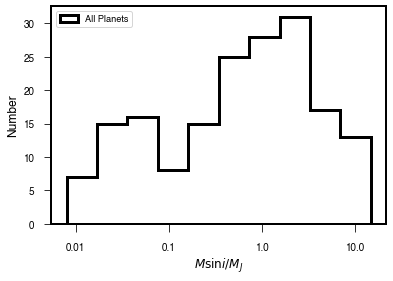

In [10]:
plotting.mass_dist(planets)

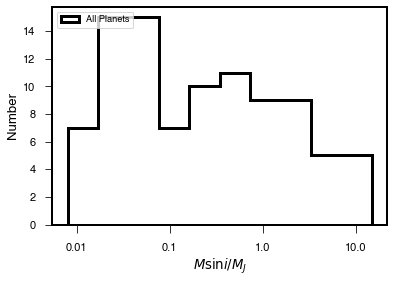

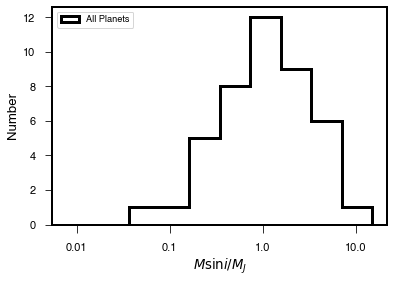

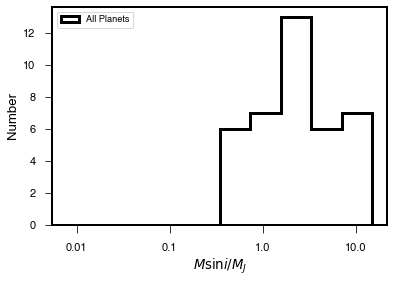

In [11]:
masses_close = planets.query('axis < 1 and mass < 15')
masses_mid   = planets.query('axis >= 1 and axis < 3 and mass < 15')
masses_far   = planets.query('axis >= 3 and mass < 15')

plotting.mass_dist(masses_close, outname='plots/close_histogram.png')
plotting.mass_dist(masses_mid, outname='plots/mid_histogram.png')
plotting.mass_dist(masses_far, outname='plots/far_histogram.png')

In [12]:
trend_names = np.unique(trends.hostname)
small_names = np.unique(planets.query('mass < 0.1 and hostname != "143761"').hostname)

In [13]:
[name for name in trend_names if name in small_names]

['156668', '45184']

### The 156668 trend is modeling out an activity alias, and the 45184 trend might be activity itself.

## Inner super-Earths and outer gas giants

In [14]:
supers = planets.query('mass < 0.1 and hostname != "143761"').reset_index(drop=True)
# HD 143761 has an inner giant and an outer small planet. Weirdo.
supernames = list(supers.hostname)
print(len(supers), len(np.unique(supers.hostname)))

41 27


In [15]:
outers = planets.query('mass >= 0.1 and hostname in @supernames and hostname != "143761"').reset_index(drop=True)
outernames = list(outers.hostname) # and axis > 0.3

In [16]:
pairs = planets.query('hostname in @outernames').reset_index(drop=True)
solos = planets.query('mass < 0.1 and not (hostname in @outernames)')

## Preliminary statistics.

In [17]:
all_outers  = planets.query('mass >= 0.1 and axis > 0.23 and hostname != "143761"')
outernames = list(all_outers.hostname)
inners = planets.query('mass < 0.1 and hostname in @outernames and hostname != "143761"').reset_index(drop=True)

In [18]:
print(len(supers), 'small planets,', len(outers), 'outer companions,', len(outers)/len(supers))

41 small planets, 11 outer companions, 0.2682926829268293


In [19]:
print(len(np.unique(supers.hostname)), 'small planet systems,', len(np.unique(outers.hostname)), 
      'inner and outer systems,', len(np.unique(outers.hostname))/len(np.unique(supers.hostname)))

27 small planet systems, 8 inner and outer systems, 0.2962962962962963


In [20]:
print(len(all_outers), 'cold giants,', len(inners), 'inner companions,', len(inners)/len(all_outers))

112 cold giants, 13 inner companions, 0.11607142857142858


In [21]:
print(len(np.unique(all_outers.hostname)), 'cold giant systems,', len(np.unique(inners.hostname)), 
      'inner and outer systems,', len(np.unique(inners.hostname))/len(np.unique(all_outers.hostname)))

82 cold giant systems, 8 inner and outer systems, 0.0975609756097561


In [22]:
giants = planets.query('mass >= 0.1')
num = np.histogram(np.log(giants.axis), bins=9, range=np.log([0.1,30]), density=False)
yerr = 0.5*np.ones(9)
fit = fit_broken(np.exp(num[1][:-1]), num[0], yerr)

In [23]:
recoveries_all = pd.read_csv('recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)

In [24]:
samples_all = pd.read_csv('samples_all_1000.csv').sample(500).reset_index(drop=True)
good_cols = [col for col in samples_all.columns if '_a' in col or '_M' in col]
samples_all = samples_all[good_cols]
samples_med = samples_all.median()
planetnames = np.unique([x[:-2] + x[-1] for x in samples_all.columns]) 

columns_good = []
for planet in planetnames:
    # remove 114762 b/c found to be face-on binary Keifer et al. (2019)
    if '114762' in planet:
        continue
    
    a_col = planet[:-2] + '_a' + planet[-1]
    M_col = planet[:-2] + '_M' + planet[-1]
    if (samples_med[a_col] > 0.02) and (samples_med[M_col] > 0.09):
        columns_good.append(a_col)
        columns_good.append(M_col)
        
samples_all = samples_all[columns_good]

for col in columns_good:
    if '_M' in col:
        samples_all[col] *= 317.8

In [25]:
broken = BrokenPowerLaw(samples_all, completey_all)
broken.max_like()

In [26]:
broken.sample(parallel=False, nsamples=1000)

100%|██████████| 1000/1000 [17:31<00:00,  1.05s/it]


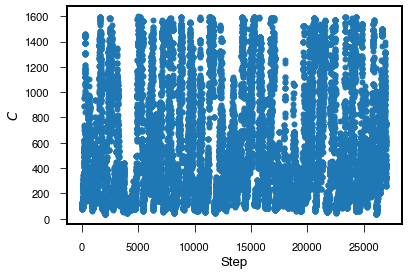

In [27]:
plotting.mcmc_trend(broken)

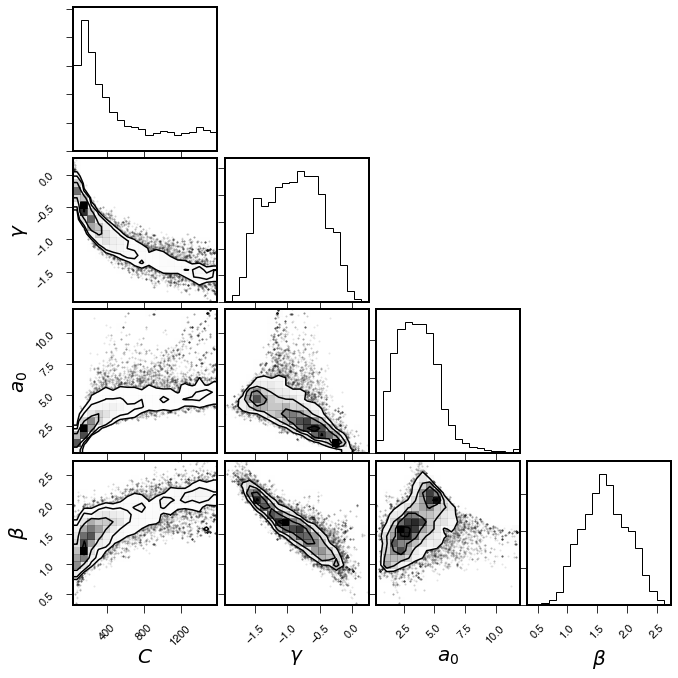

In [28]:
fig = corner.corner(broken.chains, labels = [r'$C$', r'$\gamma$', r'$a_0$', r'$\beta$'], 
                    showtitles=True, label_kwargs=dict(fontsize=20))
fig.savefig('plots/corner_broken_powerlaw.pdf')

In [29]:
broken_chains = pd.read_csv('powerlaw_chains.csv')[['C', 'beta', 'a0', 'gamma']]

In [30]:
best = broken_chains.iloc[0].values

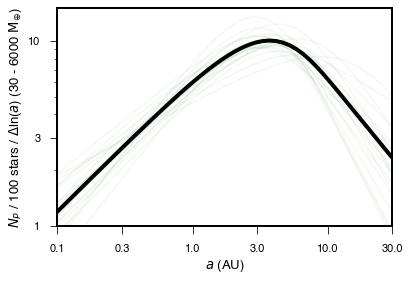

In [31]:
plotting.power_law_fit(broken_chains)

In [32]:
allbins = lngrid(0.03, 30., 30., 6000, 11, 1) 
hierarchical_one = Hierarchy(samples_all, completey_all, bins=allbins, chainname='occur_chains.csv')
hierarchical_one.max_like()

In [33]:
hierarchical_one.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [39:43<00:00,  2.38s/it]


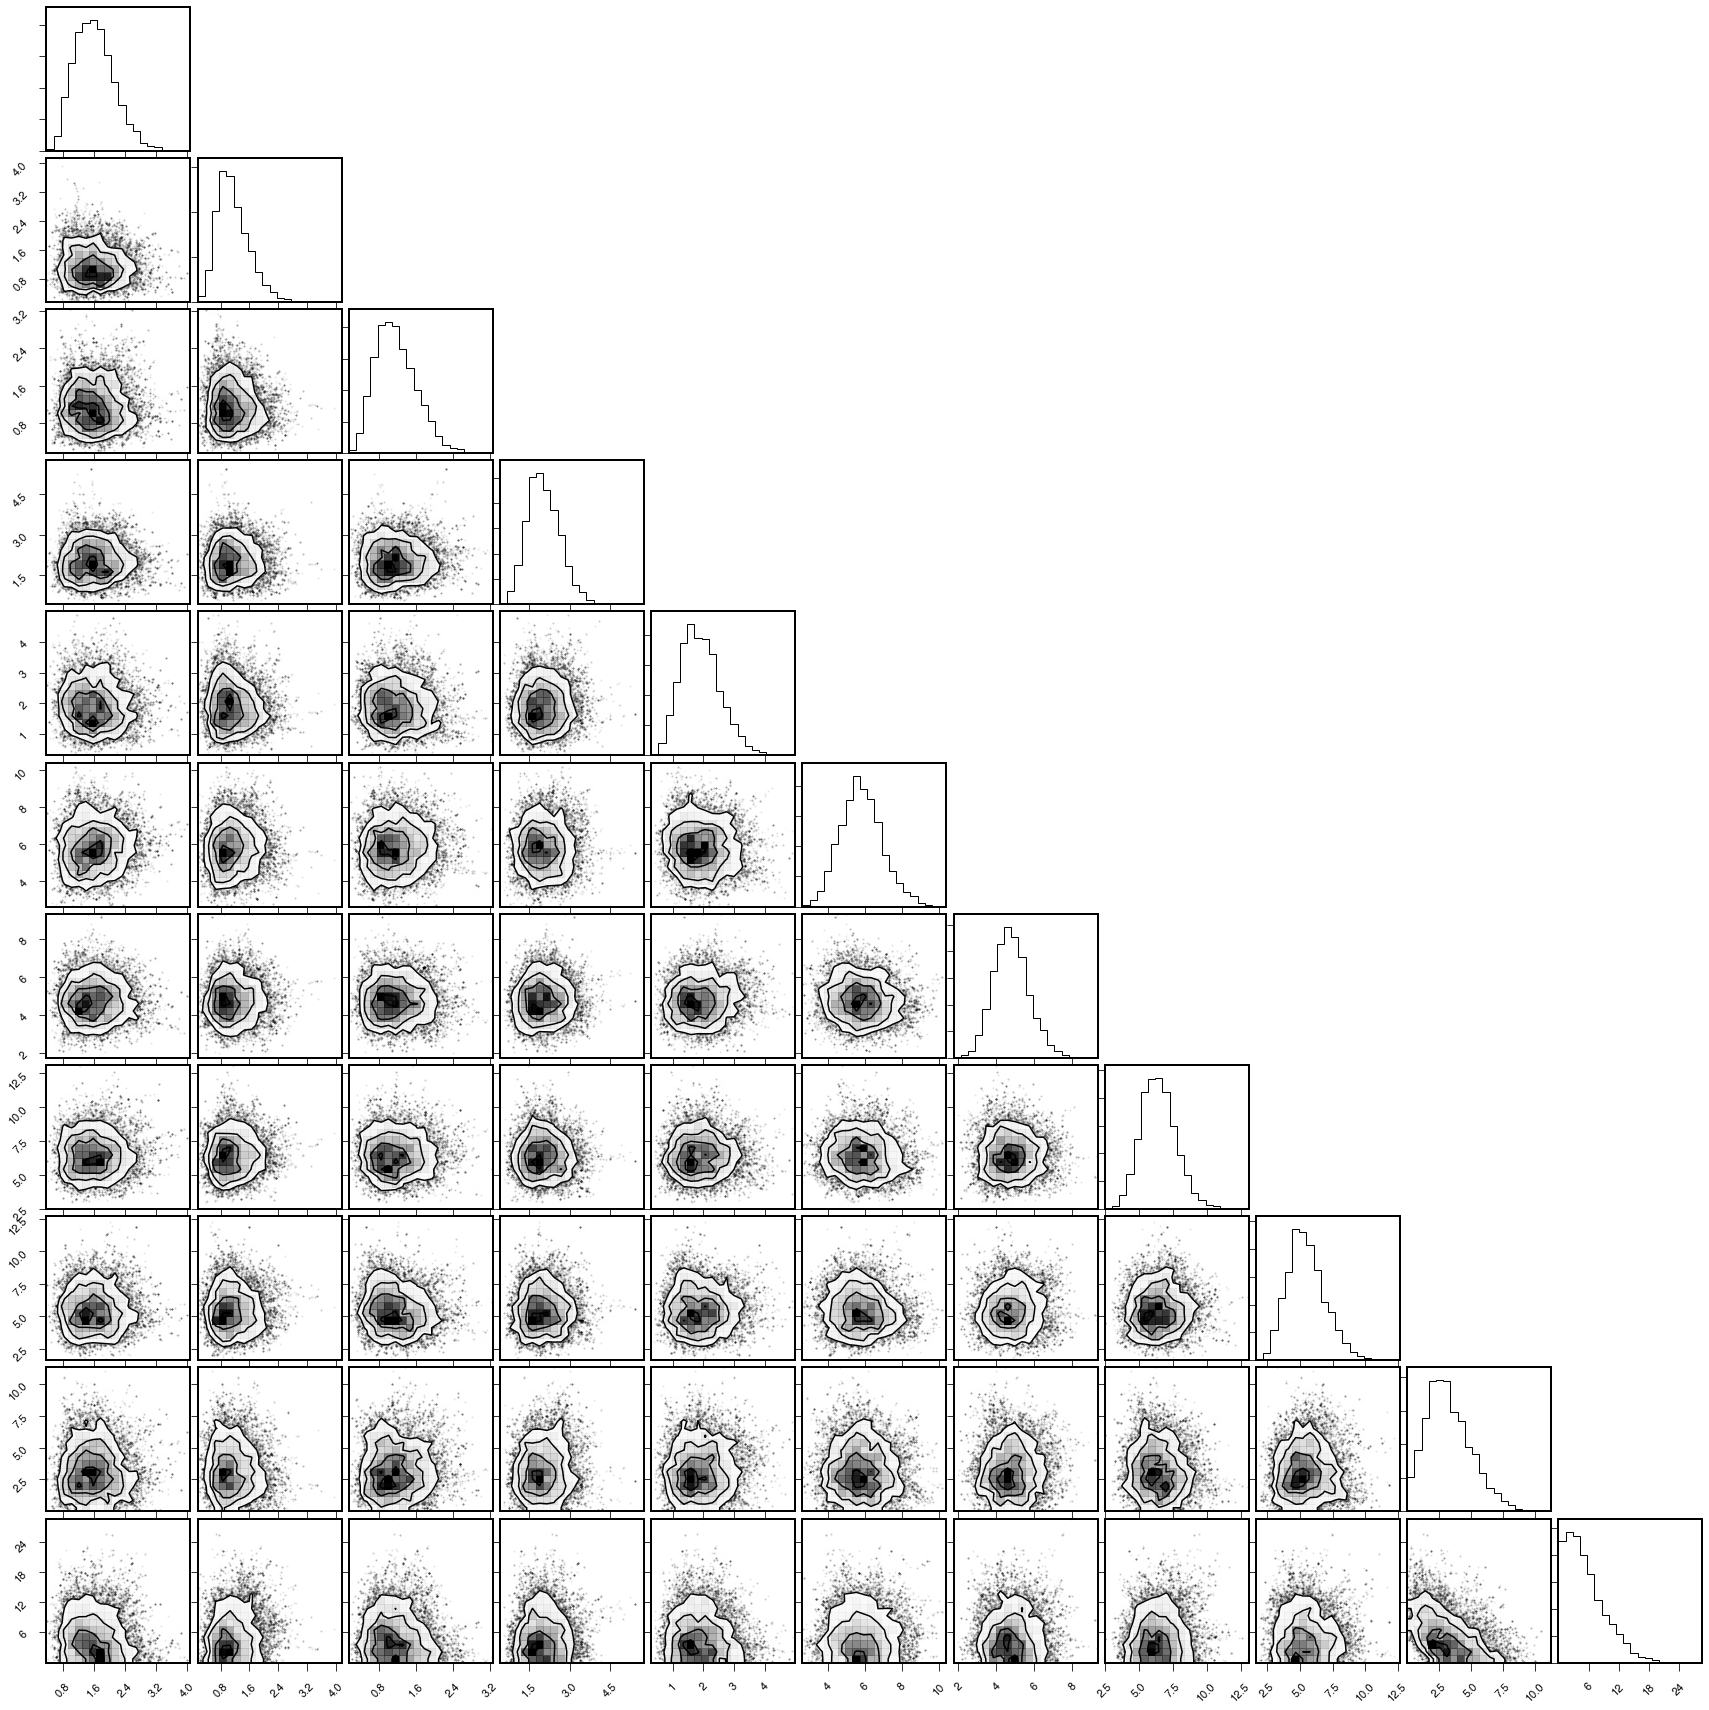

In [34]:
fig = corner.corner(hierarchical_one.chains[10000:]*hierarchical_one.bin_areas[0][0]*(100/719))
fig.savefig('plots/corner_11x1_1014.pdf')

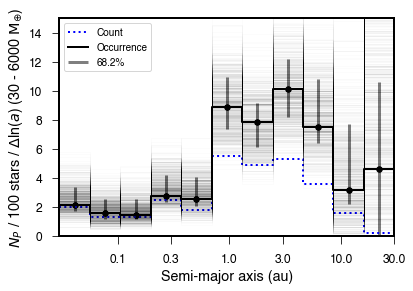

In [35]:
plotting.binned_hist(planets, allbins, hierarchical_one)

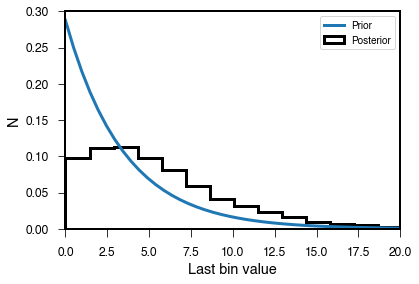

In [36]:
plotting.last_bin(hierarchical_one, chains_file='occur_chains.csv')

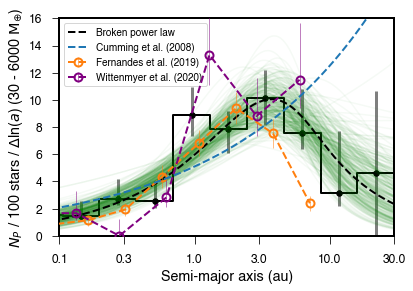

In [37]:
plotting.fit_overlay(planets, hierarchical_one, broken, allbins,
                     chains_file='occur_chains.csv',
                     outname='plots/hist_11x1_1014_hierarchy_and_broken.pdf', show_others=True)

## Redo occurrence results with 2 Msini bins per semi-major axis bin.

In [38]:
twobins = lngrid(0.03, 30., 30., 6000, 11, 2) 
hierarchical_two = Hierarchy(samples_all, completey_all, bins=twobins)
hierarchical_two.max_like()

In [39]:
hierarchical_two.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [1:30:51<00:00,  5.45s/it]


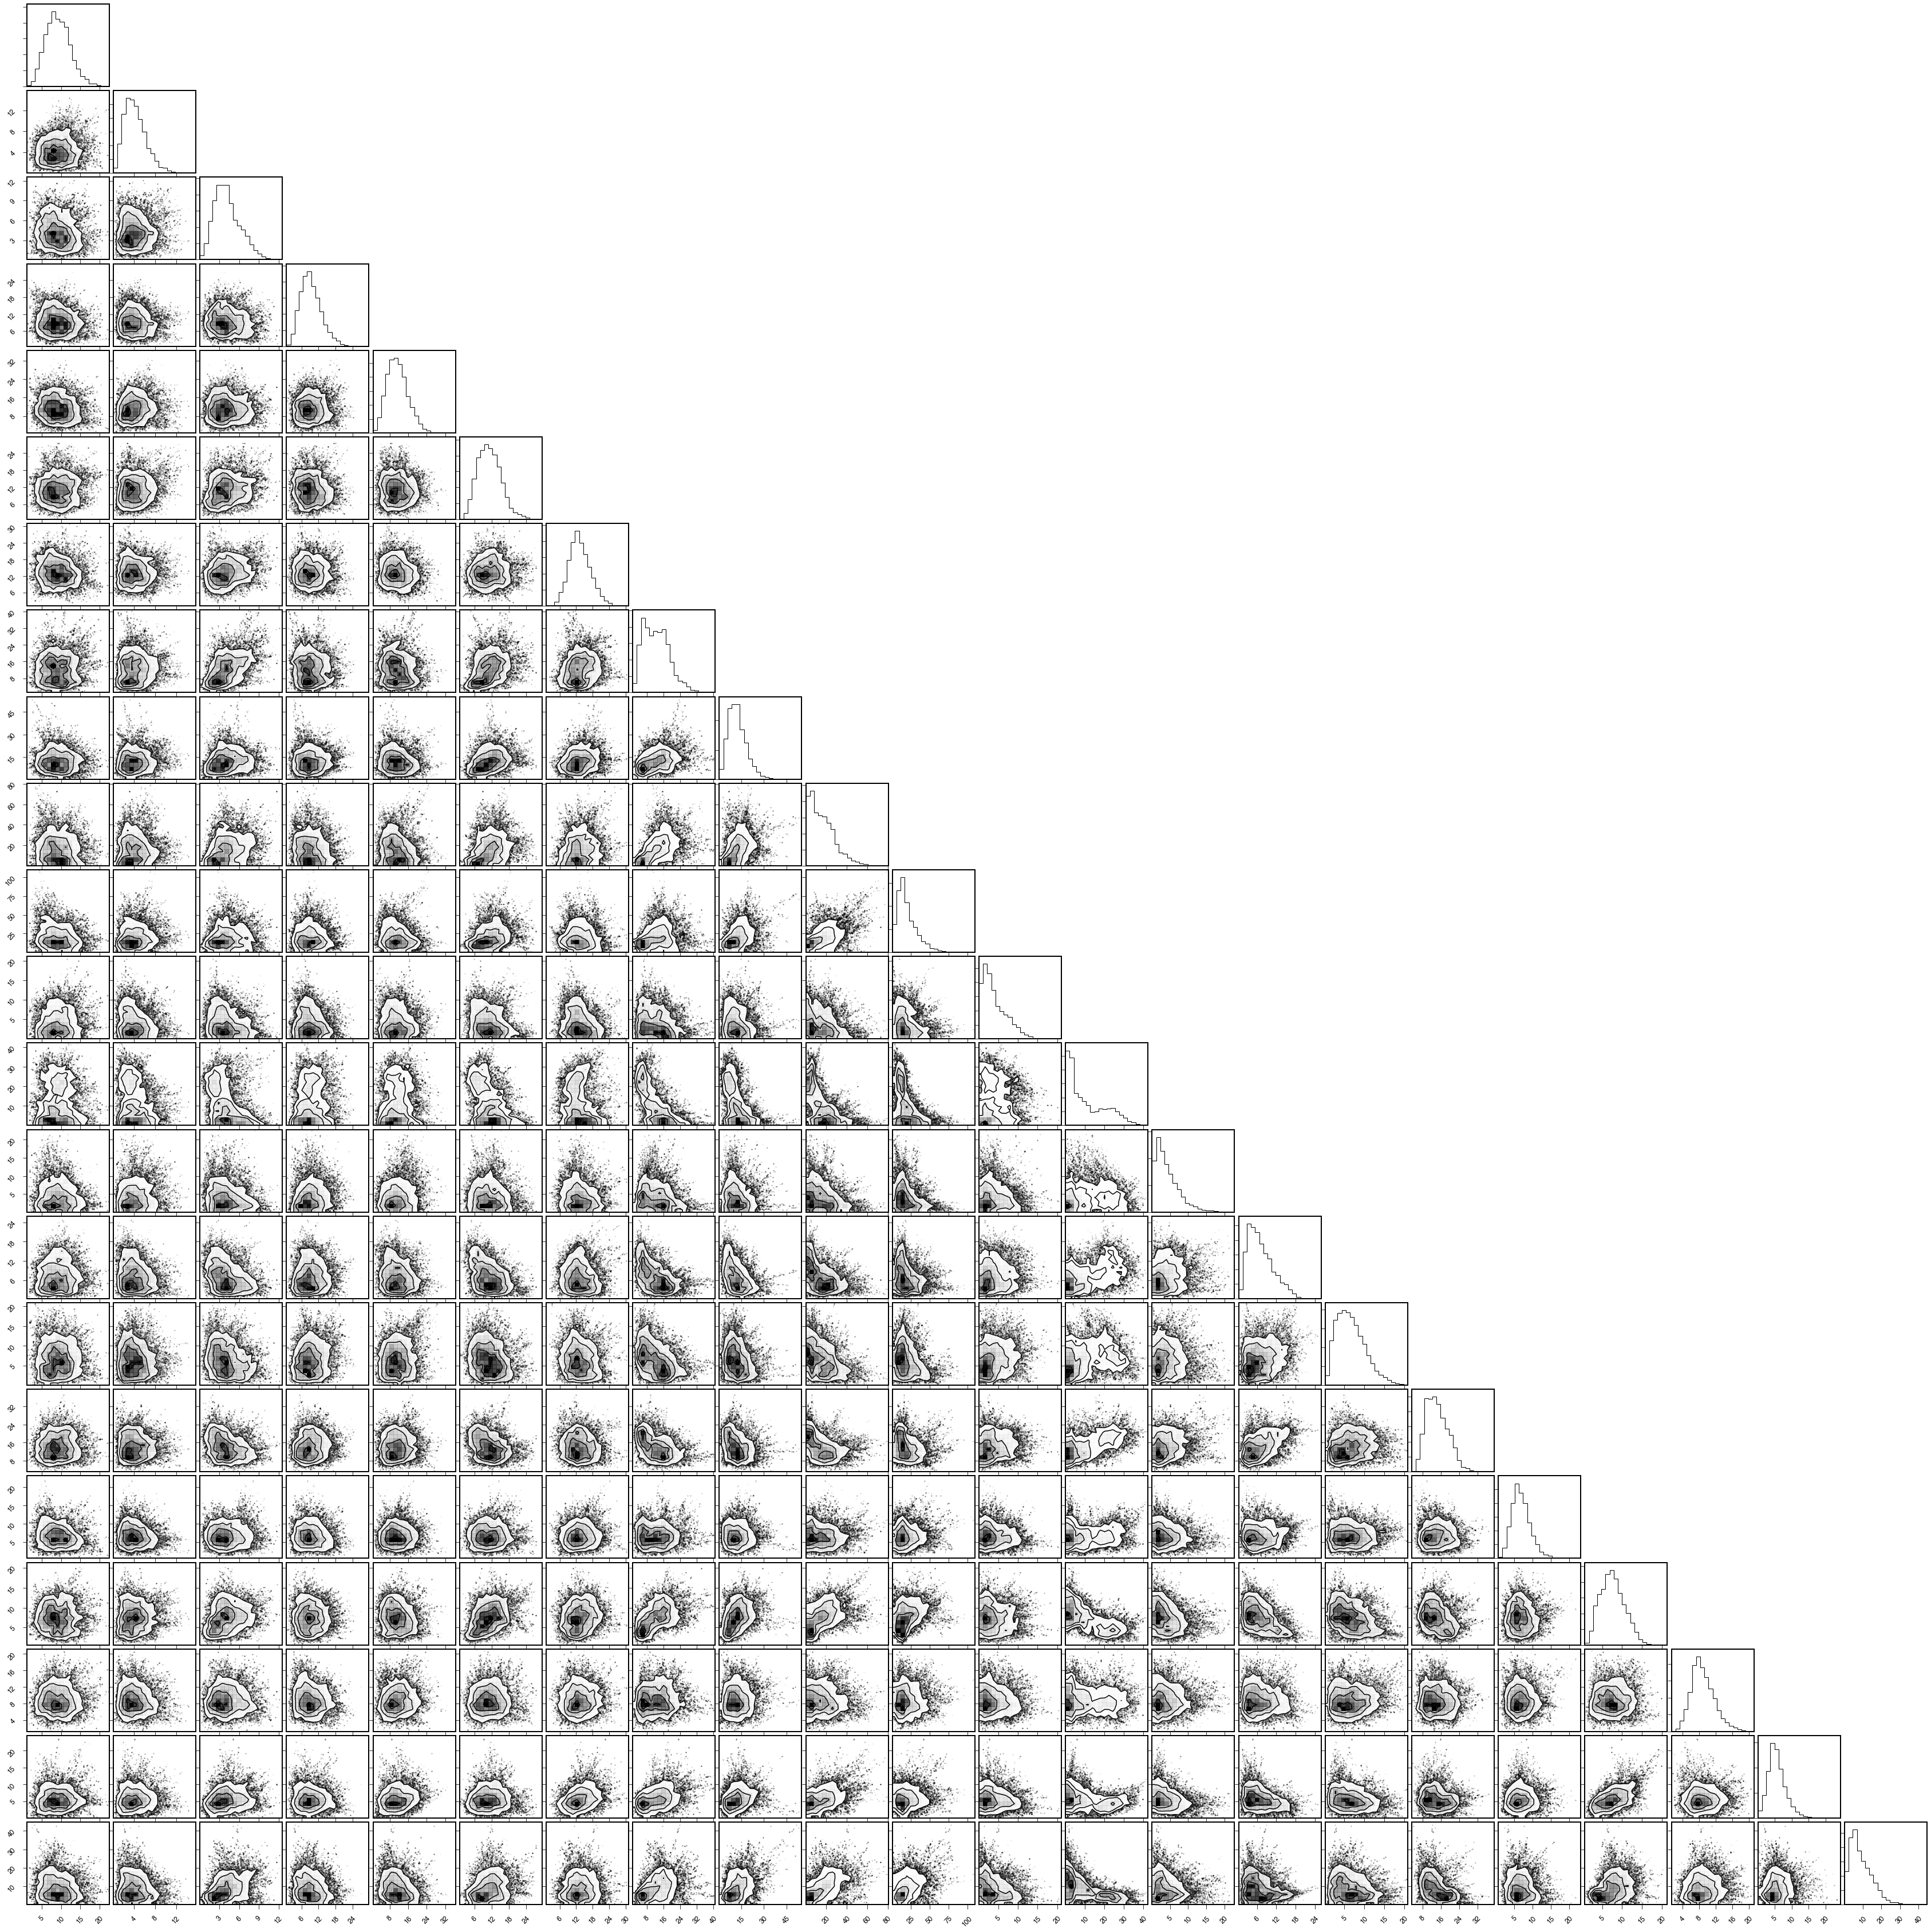

In [40]:
fig = corner.corner(hierarchical_two.chains[10000:])#*hierarchical_two.bin_areas[0][0]*(100/719))
fig.savefig('plots/corner_11x2_1026_full.pdf')

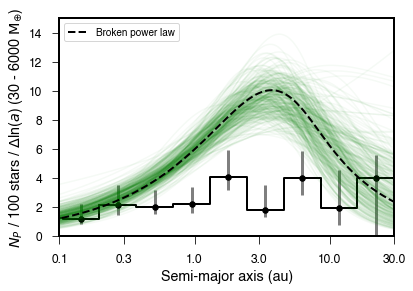

In [41]:

plotting.fit_overlay(planets, hierarchical_two, broken, twobins,  chains_file='occur_chains_11x2_1026.csv', outname='plots/hist_11x2_fancy_mode.png')

### 11X2 results seem off. Or, they're just the result of a small number of planets per bin.

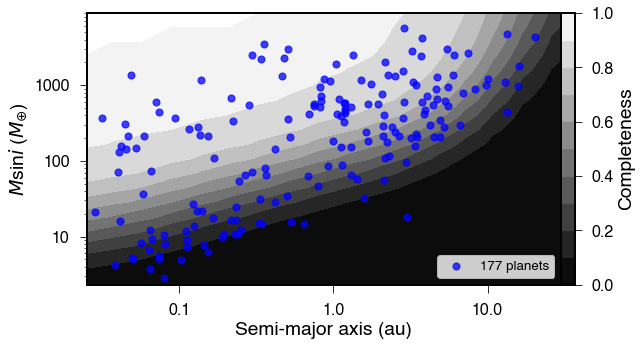

In [66]:
plotting.survey_summary(planets)

In [43]:

for table in [specmatch, planets, supers, all_outers, outers]:
    if table is specmatch:
        key = 'name'
    else:
        key = 'hostname'

    save_table(table, key, outname=retrieve_name(table)[0]+'.csv')


NameError: name 'inspect' is not defined

In [44]:
bins = lngrid(10, 50., 300, 6000, 1, 1) 
hierarchical_onebin = Hierarchy(samples_all, completey_all, bins=bins, chainname='biller_comp_chains.csv')
hierarchical_onebin.max_like()

In [45]:
hierarchical_onebin.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:59<00:00,  5.57it/s]


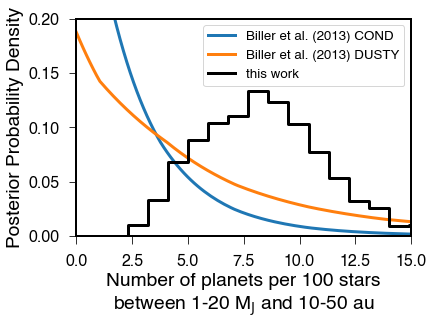

In [46]:
from scipy import interpolate

chains_db = pd.read_csv('biller_comp_chains.csv')

biller_cond = pd.read_csv('biller_cond.csv', names=['x', 'y'])
biller_cond['f'] = np.exp(biller_cond['y'])
x = np.linspace(0, 30, 200)
iy = scipy.interpolate.interp1d(biller_cond['x']*100, biller_cond['y'])
fc = np.exp(iy(x))
fc = fc / np.trapz(fc, x, dx=np.diff(x))

biller_dusty = pd.read_csv('biller_dusty.csv', names=['x', 'y'])
biller_dusty['f'] = np.exp(biller_dusty['y']) / np.sum(np.exp(biller_dusty['y']))
iy = scipy.interpolate.interp1d(biller_dusty['x']*100, biller_dusty['y'])
fd = np.exp(iy(x))
fd = fd / np.trapz(fd, x, dx=np.diff(x))


fig, ax = plt.subplots()
factor = hierarchical_onebin.bin_areas[0][0]*(100/719)
bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

prior_grid = np.linspace(0, 4*hierarchical_onebin.ceiling*factor, num=50)
ax.plot(x, fc, lw=3, label='Biller et al. (2013) COND')
ax.plot(x, fd, lw=3, label='Biller et al. (2013) DUSTY')

# ax.hist(factor*chains_db['gamma0'][1000:], bins=20, density=True, fill=False, 
#         histtype='step', color='black', lw=3, label='this work')
plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 15])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 1-20 M$_{\\rm J}$ and 10-50 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('biller_comp.pdf', dpi=1000, bbox_inches='tight')

In [47]:
bins = lngrid(10, 100., 300*5, 300*13, 1, 1) 
hierarchical_nielbin = Hierarchy(samples_all, completey_all, bins=bins, chainname='di_comp_chains.csv')
hierarchical_nielbin.max_like()
hierarchical_nielbin.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


0.5826770498425191


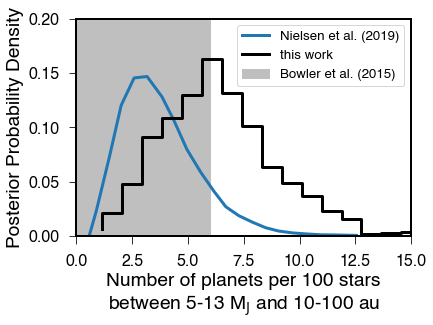

In [48]:
chains_db = pd.read_csv('di_comp_chains.csv')

nielsen = pd.read_csv('nielsen.csv', names=['x', 'y'])
nielsen['f'] = nielsen['y'] / np.sum(nielsen['y'])
print(np.trapz(nielsen['f'], nielsen['x'], dx=np.diff(nielsen['x'])))

fig, ax = plt.subplots()
factor = hierarchical_nielbin.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_nielbin.ceiling*factor, num=50)
ax.plot(nielsen['x'], nielsen['f'], lw=3, label='Nielsen et al. (2019)')

ax.axvspan(0, 6, label='Bowler et al. (2015)', color='0.75')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 15])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 5-13 M$_{\\rm J}$ and 10-100 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('nielsen_comp.pdf', dpi=1000, bbox_inches='tight')

In [49]:
cassan_bin = lngrid(0.5, 10., 100., 3000, 1, 1)

hierarchical_cas = Hierarchy(samples_all, completey_all, bins=cassan_bin, chainname='cassan_comp_chains.csv')
hierarchical_cas.max_like()
hierarchical_cas.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s]


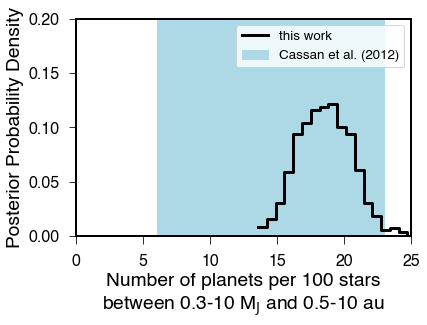

In [50]:
chains_db = pd.read_csv('cassan_comp_chains.csv')

fig, ax = plt.subplots()
factor = hierarchical_cas.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_cas.ceiling*factor, num=50)
ax.axvspan(6, 23, label='Cassan et al. (2012)', color='lightblue')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 25])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 0.3-10 M$_{\\rm J}$ and 0.5-10 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('cassan_comp.pdf', dpi=1000, bbox_inches='tight')

In [51]:
clanton_bin = lngrid(1.55, 7.2, 100., 1000, 1, 1)

hierarchical_cla = Hierarchy(samples_all, completey_all, bins=clanton_bin, chainname='clanton_comp_chains.csv')
hierarchical_cla.max_like()
hierarchical_cla.sample(parallel=False, gp=False)

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


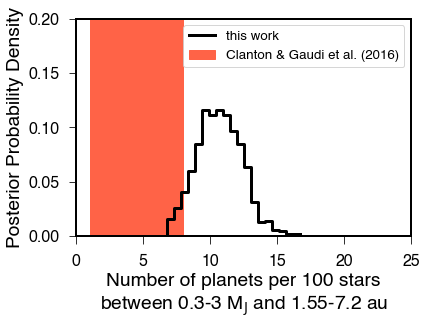

In [52]:
chains_db = pd.read_csv('clanton_comp_chains.csv')

fig, ax = plt.subplots()
factor = hierarchical_cla.bin_areas[0][0]*(100/719)
prior_grid = np.linspace(0, 4*hierarchical_cla.ceiling*factor, num=50)
ax.axvspan(1, 8, label='Clanton & Gaudi et al. (2016)', color='tomato')

bins, edges = np.histogram(factor*chains_db['gamma0'][1000:], bins=20)
bins = bins / np.sum(bins)

plt.step(edges[1:], bins, where='pre', lw=3, color='k', label='this work')
ax.set_xlim([0, 25])
ax.set_ylim([0, 0.2])
ax.set_xlabel('Number of planets per 100 stars\nbetween 0.3-3 M$_{\\rm J}$ and 1.55-7.2 au')
ax.set_ylabel('Posterior Probability Density')
ax.legend()
fig.savefig('clanton_comp.pdf', dpi=1000, bbox_inches='tight')

In [53]:
subjupbins = lngrid(0.03, 30., 30., 300, 11, 1) 
supjupbins = lngrid(0.03, 30., 300., 6000, 11, 1) 
hierarchical_sub = Hierarchy(samples_all, completey_all, bins=subjupbins[:-2],
                             chainname='occur_chains_11x1_sub.csv')
hierarchical_sup = Hierarchy(samples_all, completey_all, bins=supjupbins,
                             chainname='occur_chains_11x1_sup.csv')
hierarchical_sub.max_like()
hierarchical_sup.max_like()
hierarchical_sub.sample(parallel=False, gp=False)
hierarchical_sup.sample(parallel=False, gp=False)




100%|██████████| 1000/1000 [36:09<00:00,  2.17s/it]


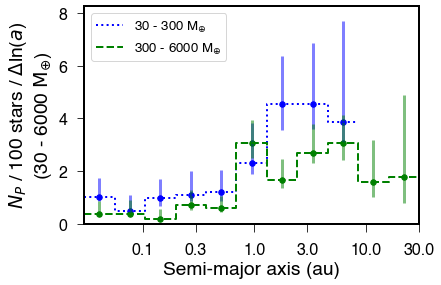

In [62]:
plotting.subjovians(hierarchical_sub, hierarchical_sup, subjupbins, supjupbins)